In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Convert 2nd order schrodinger eqn to two first order eqns as RK4 or ODEINT needs first order eqns as input 
def schrodinger_eqn(y,x,V,E):
    psi_1,psi_2 = y
    energy_diff = V-E
    dpsi_dx = np.asarray([psi_2,energy_diff*psi_1])
    return dpsi_dx

# Finds the solution of schrodinger eqn and return psi, Similar to ODEINT in MATLAB
# Runge Kutta Method: https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods
def rk4(fnc,psi0,x,V,E):
    n = len(x)
    psi = np.array([psi0]*n)
    for i in range(n-1):
        h = (x[i+1] - x[i])*0.5
        k1 = 0.5*h*fnc(psi[i],x[i],V[i],E)
        k2 = 0.5*h*fnc(psi[i]+k1,x[i]+h,V[i],E)
        k3 = 0.5*h*fnc(psi[i]+k2,x[i]+h,V[i],E)
        k4 = 0.5*h*fnc(psi[i]+k3,x[i],V[i],E)
        psi[i+1] = psi[i] + (k1 + 2.0*(k2+k3)+k4)/3.0
    return psi

# To find zeros of the function H, Newton-Raphson is another option to go for  
def find_root(psi):
    sign_of_psi = np.signbit(psi)
    detect_region_crossing = np.diff(sign_of_psi)
    roots = np.where(detect_region_crossing)[0] # [1] has info about dtype 
    return roots

# Normalizing psi
# Can take L2 norm of psi as well for normalization
def normalize(psi,flag=0):
    norm = max(psi)
    if flag==0:
        return psi*(1/norm)
    else:
        return norm
    
# Calculating energy eigen values:
# Select upper and lower bounds of energy and take the mean of it as E.
# Check no. of zeros(nodes) of psi for that particular energy value, for ground state energy there exists no node similarly for first energy state there's one node and so on. 
# If no. of nodes from above process crosses the required no. of nodes+1 count then upper bound of energy becomes equal to the mean E and the above process is repeated.
# If no. of nodes-1 is lesser then set lower bound of energy to the mean E and repeat the above process.
# For the three edge cases when nodes found equals nodes-1 or nodes or nodes+1 the energy eigen value depends on if the psi value close to the boundary is positive or negative.  
# Analogous to binary search.
def energy_vals(E_h_minus,E_h_plus,nodes,psi0,x,V):
    tolerance = 1e-12
    E_plus = E_h_plus
    E_minus = E_h_minus
    psi = [1]
    while ( abs(E_plus-E_minus)>tolerance or psi[-1]>1e-3 ):
        #print(E_plus,E_minus,psi[-1])
        E = (E_plus+E_minus)/2
        psi = rk4(schrodinger_eqn,psi0,x,V,E)[:,0]
        nodes_count = len(find_root(psi))-1
        
        if nodes_count > (nodes+1):
            E_plus = E
            continue
            
        if nodes_count < (nodes-1):
            E_minus = E
            continue
        
        if (nodes_count%2==0):
            if((psi[len(psi)-1] <= 0.0)):
                E_plus = E
            else:
                E_minus = E
                
        elif (nodes_count>0):
            if((psi[len(psi)-1] <= 0.0)):
                E_minus = E
            else:
                E_plus = E
                
        elif (nodes_count<0):
            E_minus = E
    
    return (E_minus+E_plus)*0.5



In [3]:
# Standard Potentials
def inf_pot_well(E_interval,node_val):
    psi_init = np.asarray([0.0,1.0])
    h = 0.01
    x = np.arange(-1.0,1.0+h,h)
    V = np.zeros(len(x))
    E = energy_vals(E_interval[0],E_interval[1],node_val,psi_init,x,V)
    psi = rk4(schrodinger_eqn,psi_init,x,V,E)[:,0] # [:,1] gives dpsi/dx
    
    # Turning Points/Boundary
    x1 = -1.0
    x2 = 1.0
    return E,normalize(psi),x,x1,x2,V

def harmonic_oscillator(E_interval,node_val):
    psi_init = np.asarray([0.0,1.0])
    h = 0.01
    l = 3
    s = 0
    x = np.arange(-10.0+h,10.0+h,h)
    V = (x**2)/2
    E = energy_vals(E_interval[0],E_interval[1],node_val,psi_init,x,V)
    psi = rk4(schrodinger_eqn,psi_init,x,V,E)[:,0] # [:,1] gives dpsi/dx
    
    # Turning Points/Boundary
    x1 = -1.0*np.sqrt(2*E)
    x2 = -x1
    return E,normalize(psi),x,x1,x2,V

def poschl_teller(E_interval,node_val):
    psi_init = np.asarray([0.0,1.0])
    h = 0.01
    l = 3
    s = 0
    x = np.arange(-20.0+h,20.0+h,h)
    #V = 5.0/(np.cosh(2*x)**2)
    e = 1e-33
    V = e*((1*(x**3) + 1*(x**2) + 1*x+1)/((x**3)*((x+3)**2)))
    E = energy_vals(E_interval[0],E_interval[1],node_val,psi_init,x,V)
    psi = rk4(schrodinger_eqn,psi_init,x,V,E)[:,0] # [:,1] gives dpsi/dx
    
    # Turning Points/Boundary
    x1 = -1.0*(np.arccosh(np.sqrt(5.0/E)))
    x2 = -x1
    return E,normalize(psi),x,x1,x2,V

Begin!


C:\Users\Sidhanth\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in double_scalars
  """


0.026471808788038412 1


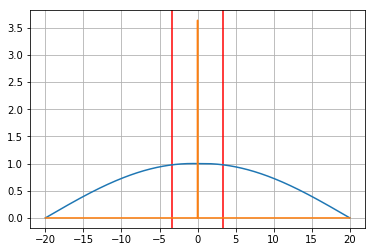

0.09874543104558715 2


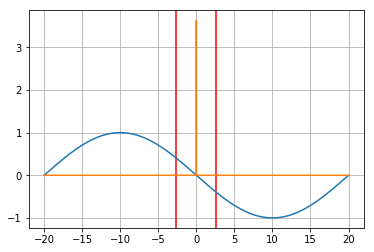

0.2239918723969444 3


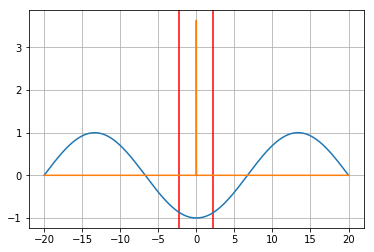

0.39498196794786855 4


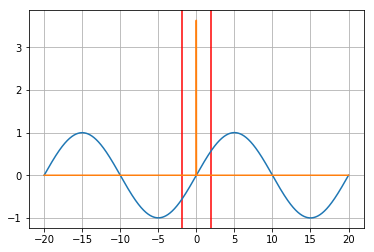

End


In [4]:
# Main and plotting

E = [-5000.0,200000.0]
nodes = np.arange(1,5,1)

print('Begin!')
for node in nodes:
    energy,psi,x,x1,x2,V = poschl_teller(E,node)
    print(energy,node)
    plt.axvline(x=x1,color='r')
    plt.axvline(x=x2,color='r')
    plt.plot(x,psi,x,V)
    plt.grid()
    plt.show()
    
print('End')

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
